In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable

## only need the nu_spec module
import nu_spec_code as nu_spec

## to fit the model
from scipy.optimize import minimize

## for MCMC
import emcee
import corner

%matplotlib notebook

# What's in this file?

We initially take the event file from the NuSTAR observation (nu80415201001A06_chu2_S_cl.evt file) and filter it using the NuSTAR data analysis pipeline, nupipeline, which returns nu80415201001A06_chu2_S_cl_grade0.evt. The code run is:

- nuscreen infile=nu80415201001A06_chu2_S_cl.evt gtiscreen=no evtscreen=yes gtiexpr=NONE gradeexpr=0 statusexpr=NONE outdir=./ hkfile=./nu80415201001A_fpm.hk outfile=nu80415201001A06_chu2_S_cl_grade0.evt

We then create the spectral file (.pha), the file with the effective areas of the event (.arf), and the redistribution matrix file (.rmf) for the observation:

- nuproducts indir=./ instrument=FPMA steminputs=nu80415201001 outdir=./ extended=no runmkarf=yes runmkrmf=yes infile=nu80415201001A06_chu2_S_cl_grade0.evt bkgextract=no srcregionfile=./fpma.reg attfile=./nu80415201001_att.fits hkfile=./nu80415201001A_fpm.hk 

The following code uses the .pha, .arf, and the .rmf to produce a NuSTAR count flux spectrum from the .pha file, read in effective areas from the .arf file, create the redistribution matrix from the .rmf file, thus creating the spectral response matrix for the observation.

Knowing the spectral response matrix, and creating a simple power law model in photon flux space, a count flux model can be produced and compared to the observed count flux spectrum.

This model fitting can then be subject to MCMC analysis.

# Read in .pha file, create count flux spectrum

The funciton nustar_FluxCtsSpec() uses another function read_pha() which calls astropy to read in the .pha file. Then the channels edges of read_pha() are taken and converted into the energy centre of the bin, the error is half the bins width, count flux for the energy bin, and errors on the count flux calculated as:

\begin{align}
F_{error} = \frac{ \sqrt{counts}}{ binWidth_{keV} \times livetime}
\end{align}

In [2]:
d_pha = 'spectralData/'
f_pha = 'nu80415201001A06_chu2_S_cl_grade0_sr.pha'
channel, channel_error, counts, counts_error = nu_spec.nustar_FluxCtsSpec(d_pha+f_pha)

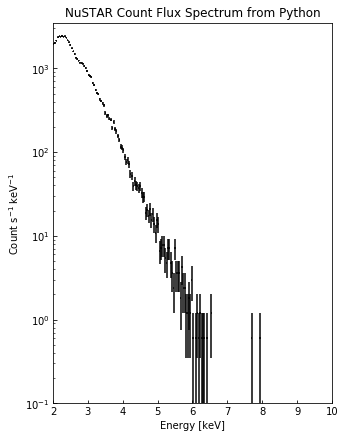

In [3]:
fig = plt.figure(figsize=(5,7))
ax = fig.gca()
ax.tick_params(axis='both', which='both', direction='in')

## plot spectrum created from Python
plt.errorbar(channel, 
             counts, 
             xerr=channel_error, 
             yerr=counts_error, 
             color='k', 
             fmt='.',
             markersize=0.01)
ax.set_xlim([2,10])
ax.set_ylim([0.1,3500])
ax.set_title('NuSTAR Count Flux Spectrum from Python')
ax.set_ylabel('Count s$^{-1}$ keV$^{-1}$')
ax.set_yscale('log')
ax.set_xlabel('Energy [keV]')

plt.show()

# Read in .arf file (ancillary response file)

The effective areas for the energies (in cm$^{2}$) are read in from the .arf file.

In [4]:
d_arf = 'spectralData/'
f_arf = 'nu80415201001A06_chu2_S_cl_grade0_sr.arf'
e_lo, e_hi, eff_area = nu_spec.read_arf(d_arf+f_arf)
e_mid = (e_hi + e_lo)/2 ## same as channel above

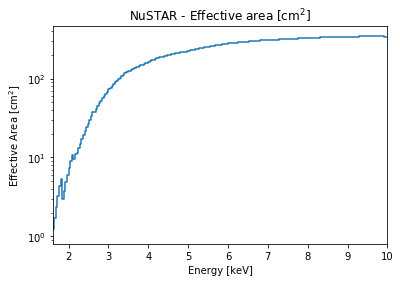

In [5]:
fig = plt.figure()

plt.plot(e_mid, eff_area,drawstyle='steps-mid')
plt.xlim([1.6,10])
plt.title('NuSTAR - Effective area [cm$^{2}$]')
plt.ylabel('Effective Area [cm$^{2}$]')
plt.xlabel('Energy [keV]')
plt.yscale('log')
plt.show()

# Read in .rmf file (redistribution matrix file)

Use the .rmf file to produce the redistribution matrix. The read_rmf() function uses the astropy package to read in the .rmf data and header information.

In [6]:
d_rmf = 'spectralData/'
f_rmf = 'nu80415201001A06_chu2_S_cl_grade0_sr.rmf'
e_lo, e_hi, ngrp, fchan, nchan, matrix = nu_spec.read_rmf(d_rmf+f_rmf)

col2arr_py() is pretty much from:

- https://lost-contact.mit.edu/afs/physics.wisc.edu/home/craigm/lib/idl/util/vcol2arr.pro

In [7]:
fchan_array = nu_spec.col2arr_py(fchan)
nchan_array = nu_spec.col2arr_py(nchan)

The vrmf2arr_py function is heavily from:

- https://lost-contact.mit.edu/afs/physics.wisc.edu/home/craigm/lib/idl/spectral/rmfread.pro

and

- https://lost-contact.mit.edu/afs/physics.wisc.edu/home/craigm/lib/idl/spectral/vrmf2arr.pro

In [8]:
mat_array = nu_spec.vrmf2arr_py(data=matrix,  
                                n_grp_list=ngrp,
                                f_chan_array=fchan_array, 
                                n_chan_array=nchan_array)

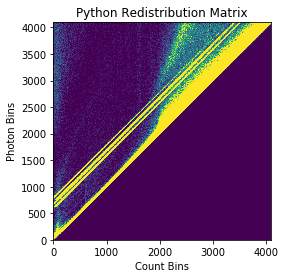

In [9]:
from matplotlib.colors import Normalize

fig,axs = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,4))

# Redistribution matrix [counts per photon]
## Python rdm
axs.imshow(mat_array, aspect=1, origin='lower', norm=Normalize(vmin=0,vmax=0.00005))
axs.set_title('Python Redistribution Matrix')
axs.set_ylabel('Photon Bins')
axs.set_xlabel('Count Bins')
plt.show()

# Total Spectral Response, SRM = rmf#arf [counts per photon x cm ^2]

See https://github.com/ianan/nsigh_nov14/blob/master/make_ns_srm.pro for spectral response matrix creation too.

In [10]:
srm = nu_spec.make_nusrm(rmf_matrix=mat_array, arf_array=eff_area)

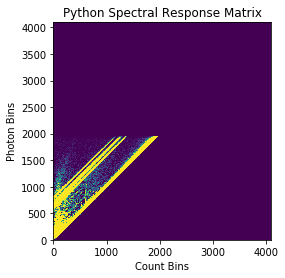

In [11]:
from matplotlib.colors import LogNorm

fig,axs = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,4))
axs.imshow(srm, origin='lower', norm=Normalize(vmax=0.001))
axs.set_title('Python Spectral Response Matrix')
axs.set_ylabel('Photon Bins')
axs.set_xlabel('Count Bins')
plt.show()

# Define some models to fit

In [12]:
def test_model_powerlaw(energies, constant, power):
    return constant*np.array(energies, dtype=float)**(-power)

# constant is [photon s^-1 keV^-1 cm^-2]
# power is the spectral index

In [13]:
def test_model_brokenpowerlaw(energies, constant, power1, brk, power2):
    model_spec = []
    for e in energies:
        if e < brk:
            model_spec.append(constant*e**(-power1))
        else:
            model_spec.append(constant*e**(power2-power1)*e**(-power2))
    return model_spec

## Get modelled counts spectrum

Have how the physical photon (y-axis) is converted and sorted into the actual detector channels (x-axis) - Spec Resp

Find the number of photons at each energy (photon spectrum) and multiply each energy seen by the number of photons for 
For that energy range to get a 2D matrix of the counts produced by one energy across several detector channels.

Sum the columns (total counts seen by the detector from multiple energy ranges) to get the observed count spectrum

To get a model from the spectral response and a photon spectrum model:

\begin{align}
Counts_{Model} = Photon_{Model} * SRM
\end{align}

where Photon$_{Model}$ is a 1 row, n columns array and SRM is and n by n array.

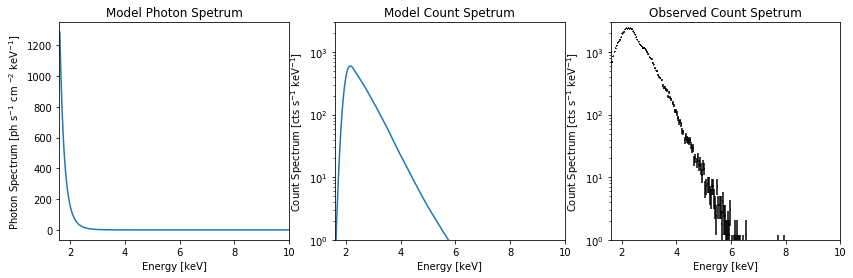

In [14]:
fig,axs = plt.subplots(1,3, sharex=True, figsize=(14,4))
axs[0].plot(channel, 
            test_model_powerlaw(channel, 20**4, 10))
axs[0].set_title('Model Photon Spetrum')
axs[0].set_xlabel('Energy [keV]')
axs[0].set_ylabel('Photon Spectrum [ph s$^{-1}$ cm $^{-2}$ keV$^{-1}$]')
axs[0].set_xlim([1.6,10])

axs[1].plot(channel, 
            nu_spec.make_model(channel, test_model_powerlaw, parameters=[20**4, 10], srm=srm))
axs[1].set_title('Model Count Spetrum')
axs[1].set_xlabel('Energy [keV]')
axs[1].set_ylabel('Count Spectrum [cts s$^{-1}$ keV$^{-1}$]')
axs[1].set_ylim([1.,3000])
axs[1].set_yscale('log')

axs[2].errorbar(channel, 
             counts, 
             xerr=channel_error, 
             yerr=counts_error, 
             color='k', 
             fmt='.',
             markersize=0.01)
axs[2].set_title('Observed Count Spetrum')
axs[2].set_xlabel('Energy [keV]')
axs[2].set_ylabel('Count Spectrum [cts s$^{-1}$ keV$^{-1}$]')
axs[2].set_ylim([1.,3000])
axs[2].set_yscale('log')

plt.show()

# Try Maximum likelihood approach too

## Likelihood

This likelihood function is similar to the CSTAT on provided:
    
- https://cxc.harvard.edu/sherpa/statistics/   

In [15]:
def minus_log_poisson_likelihood(mod_const_and_power, obs_counts, channel, total_response):
    # allow the model to be varied to minimize -ln(L)
    
    mu = nu_spec.make_model(channel, 
                    test_model_powerlaw, 
                    [mod_const_and_power[0], mod_const_and_power[1]], 
                    total_response)
    
    # mu number of counts predicted
    # obs_counts is the number of counts
    likelihoods = []
    for i in range(len(obs_counts)):
        if obs_counts[i] <= 0:
            l = 0
        else:
            l = obs_counts[i]*( np.log(mu[i]/obs_counts[i]) + 1 ) - mu[i]
        l = l if np.isfinite(l) else 0 ## if there are no counts, I don't want it to affect the result
        likelihoods.append(l)
    return -np.sum(likelihoods)

# Maximise the Likelihood

Fit just up to the last count: counts[:125], channel[:125].

In [16]:
initial = [20**4, 10]
methods = [None, 'Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'COBYLA', 'TNC', 'SLSQP'] 
method = methods[0]
# L-BFGS-B and COBYLA change the fit the most compared to the others
soln = minimize(minus_log_poisson_likelihood, initial, args=(counts[:125], channel[:125], srm), method=method)

# Work out residuals of Max. Likelihood fit to get Chi^2

In [17]:
# maximum likelihood
model_cts_minimize = nu_spec.make_model(channel, test_model_powerlaw, [*soln.x], srm)
res_lh = [(counts[i] - model_cts_minimize[i])/counts_error[i] if counts_error[i]>0 else 0 for i in range(len(counts_error))]
print('Constant and power law: ', soln.x)
print('Minimized log(L): ', minus_log_poisson_likelihood(soln.x, counts, channel, srm))
print('Chi^2 from Minimized log(L): ', np.sum(np.array(res_lh)**2))

Constant and power law:  [1.50506906e+06 1.06446103e+01]
Minimized log(L):  14177.887303981917
Chi^2 from Minimized log(L):  14991.284087934962


/scratch/marduk/kris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


# Plot results

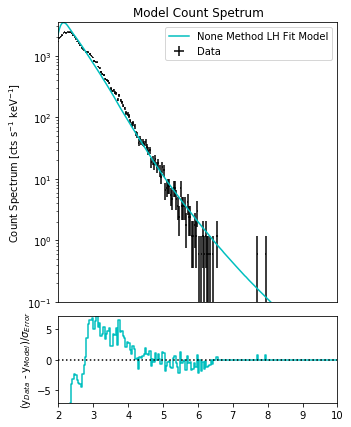

In [18]:
fig, axs = plt.subplots(figsize=(5,7))
## plot fits
axs.plot(channel, model_cts_minimize, label=str(method)+' Method LH Fit Model', color='c')
axs.set_title('Model Count Spetrum')
axs.set_xlabel('Energy [keV]')
axs.set_ylabel('Count Spectrum [cts s$^{-1}$ keV$^{-1}$]')
axs.set_ylim([0.1,3500])
axs.set_yscale('log')
axs.xaxis.set_tick_params(labelbottom=False)
axs.get_xaxis().set_visible(False)

## plot data
axs.errorbar(channel, counts,xerr=channel_error, yerr=counts_error, color='k', fmt='.',markersize=0.01, label='Data')
plt.legend()

#residuals plotting
divider = make_axes_locatable(axs)
res = divider.append_axes('bottom', 1.2, pad=0.2, sharex=axs)
res.plot(channel, res_lh, drawstyle='steps-mid', color='c')
res.axhline(0, linestyle=':', color='k')
res.set_xlim([2,10])
res.set_ylim([-7,7])
res.set_ylabel('(y$_{Data}$ - y$_{Model}$)/$\sigma_{Error}$')

axs.set_xlim([2,10])
plt.show()


# MCMC and Maximum likelihood

In [19]:
def prior(constant, power):
    if 10**4 < constant <10**8 and 5 < power < 9:
        return 0.0
    return -np.inf

In [20]:
def prob(mod_const_and_power, obs_counts, channel, total_response):
    lp = prior(*mod_const_and_power)
    if not np.isfinite(lp):
        return -np.inf
    ## 'lp -' as its the negative sum of logs
    return lp - minus_log_poisson_likelihood(mod_const_and_power, obs_counts, channel, total_response)

In [21]:
ndim, nwalkers = 2, 10000
pos = [soln["x"] + [1000*np.random.randn(1)[0], 0.1*np.random.randn(1)[0]] for i in range(nwalkers)]

In [22]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, prob, args=(counts[:125], channel[:125], srm))
sampler.run_mcmc(pos, 500, progress=True);

  0%|          | 0/500 [00:00<?, ?it/s]/scratch/marduk/kris/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 500/500 [00:33<00:00, 14.74it/s]


# Get corner plot of the MCMC

In [23]:
samples = sampler.chain.reshape((-1, ndim))

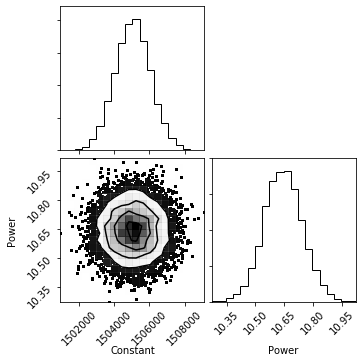

In [24]:
fig = corner.corner(samples, labels=["Constant", "Power"])

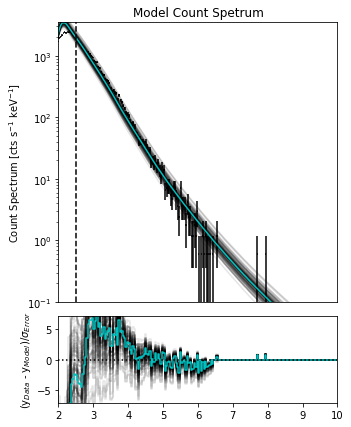

In [25]:
fig,axs = plt.subplots(figsize=(5,7))

# get residuals for all the trys
for_ress = []
for constant, power in samples[np.random.randint(len(samples), size=100)]:
    model_cts_try = nu_spec.make_model(channel, test_model_powerlaw, [constant, power], srm)
    for_ress.append(model_cts_try)
    plt.plot(channel, model_cts_try, color="k", alpha=0.1)

# plot the maximised likelihood solution
axs.plot(channel, model_cts_minimize, label=str(method)+' Method LH Fit Model', color='c')
axs.set_title('Model Count Spetrum')
axs.set_xlabel('Energy [keV]')
axs.set_ylabel('Count Spectrum [cts s$^{-1}$ keV$^{-1}$]')
axs.set_ylim([0.1,3500])
axs.set_yscale('log')
axs.xaxis.set_tick_params(labelbottom=False)
axs.get_xaxis().set_visible(False)

# plot data
axs.errorbar(channel, counts,xerr=channel_error, yerr=counts_error, color='k', fmt='.',markersize=0.01, label='Data')
axs.axvline(x=2.5, c='k', linestyle='--')

#residuals plotting
divider = make_axes_locatable(axs)
res = divider.append_axes('bottom', 1.2, pad=0.2, sharex=axs)
for m in for_ress:
    r = [(counts[i] - m[i])/counts_error[i] if counts_error[i]>0 else 0 for i in range(len(counts_error))]
    res.plot(channel, r, drawstyle='steps-mid', color='k', alpha=0.1)
res.plot(channel, res_lh, drawstyle='steps-mid', color='c')
res.axhline(0, linestyle=':', color='k')
res.set_xlim([2,10])
res.set_ylim([-7,7])

res.set_ylabel('(y$_{Data}$ - y$_{Model}$)/$\sigma_{Error}$')

#fig.text(.5, .05, txt, ha='center')
axs.set_xlim([2,10])
plt.show()